## Clothing Classification Training

In [1]:
import numpy as np
from glob import glob
import pickle

# import necessary keras modules
from keras.preprocessing import image 
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping  
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization

# custom functions
from layer_output import get_dense_layer, all_dense_data, path_to_tensor, paths_to_tensor
from loading import load_files       

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path, ignore_files='.DS_Store')
    clothing_files = np.array(data['filenames'])
    clothing_targets = np_utils.to_categorical(np.array(data['target']), 14)
    return clothing_files, clothing_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('../data/clothing2/train')
valid_files, valid_targets = load_dataset('../data/clothing2/validate')
test_files, test_targets = load_dataset('../data/clothing2/test')

# load list of clothing names
clothing_names = [item[24:-1] for item in sorted(glob("../data/clothing2/train/*/"))]

# print info about the dataset
print(f'There are {len(clothing_names)} total clothing categories.')
print(f'There are {len(np.hstack([train_files, valid_files, test_files]))} total clothing images.\n')
print(f'There are {len(train_files)} training clothing images.')
print(f'There are {len(valid_files)} validation clothing images.')
print(f'There are {len(test_files)} test clothing images.')

There are 14 total clothing categories.
There are 3147 total clothing images.

There are 2477 training clothing images.
There are 339 validation clothing images.
There are 331 test clothing images.


**Convert all paths to a stack of tensors**

In [3]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
# rescale the images by dividing every pixel in every image by 255.
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 331/331 [00:02<00:00, 114.32it/s]


In [4]:
model = Sequential()

# Define the architecture.
model.add(BatchNormalization(input_shape=(224, 224, 3)))
model.add(Conv2D(filters=16, kernel_size=5, strides=2, padding='valid', activation='relu', 
                 input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=5, strides=2, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(rate=0.3))
model.add(Conv2D(filters=64, kernel_size=2, strides=2, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())

model.add(Dense(units=300, activation='relu', name='vectors')) # extract vectors from here and cluster
model.add(Dropout(rate=0.3))
model.add(Dense(len(clothing_names), activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 16)      1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 32)        12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 64)          8256      
__________

In [5]:
# compile the model 
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [6]:
# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

datagen_train.fit(train_tensors)

In [7]:
epochs = 50

early_stop = EarlyStopping(monitor='val_loss', patience=5)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)
history = model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=10, callbacks=[checkpointer, early_stop], verbose=1,)

Train on 2477 samples, validate on 339 samples
Epoch 1/50
2477/2477 [==============================] - 18s 7ms/step - loss: 2.2393 - acc: 0.2358 - val_loss: 1.7965 - val_acc: 0.4100

Epoch 00001: val_loss improved from inf to 1.79654, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 2/50
2477/2477 [==============================] - 16s 7ms/step - loss: 1.8109 - acc: 0.3932 - val_loss: 1.5955 - val_acc: 0.4277

Epoch 00002: val_loss improved from 1.79654 to 1.59553, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 3/50
2477/2477 [==============================] - 16s 6ms/step - loss: 1.5539 - acc: 0.4885 - val_loss: 1.3611 - val_acc: 0.5339

Epoch 00003: val_loss improved from 1.59553 to 1.36106, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 4/50
2477/2477 [==============================] - 16s 7ms/step - loss: 1.4172 - acc: 0.5301 - val_loss: 1.2734 - val_acc: 0.5988

Epoch 00004: val_loss improved from 1.36106 to 1.27336, saving mo

## Graph of training/validation Accuracy and Loss

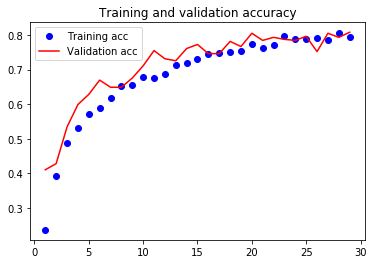

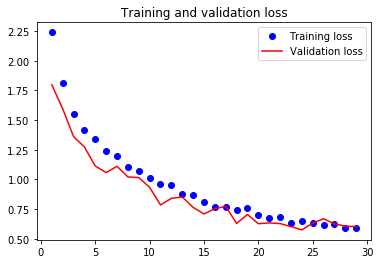

In [8]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', c='red')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', c='red')
plt.title('Training and validation loss')
plt.legend();

In [9]:
# get index of predicted item for each image in test set
clothing_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(clothing_predictions)==np.argmax(test_targets, axis=1))/len(clothing_predictions)
print('Test accuracy: {}'.format(round(test_accuracy, 4)))  #better than 77.9?

Test accuracy: 80.6647


In [10]:
# https://towardsdatascience.com/visualizing-intermediate-activation-in-convolutional
# -neural-networks-with-keras-260b36d60d0
model.save('saved_models/clothes2_cnn.h5')
# load the model with best validation loss
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

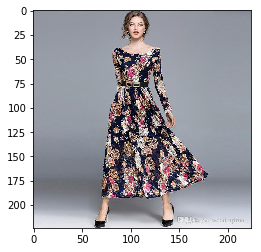

(1, 224, 224, 3)


In [11]:
img_path = '../data/clothing2/test/spring_floral_dresses/spring_floral_dresses210.jpg'
img_tensor = path_to_tensor(img_path)
img_tensor /= 255.
plt.imshow(img_tensor[0])
plt.show()
print(img_tensor.shape)

In [12]:
# predicting images
images = np.vstack([img_tensor])
classes = model.predict_classes(images, batch_size=10)
print("Predicted class is:", clothing_names[int(classes)])

Predicted class is: spring_floral_dresses


## Get a matrix of all images Dense layer stacked

In [36]:
# concat all files from train, validate, test for more robust clustering and recommendations
# np.concatenate(train_files, valid_files) # + test_files

In [13]:
all_dense, dense_df = all_dense_data(model, train_files)
pickle.dump(dense_df, open("saved_models/dense_clothing_df.pickle", "wb" ))
print(all_dense.shape)
print(dense_df.shape)
dense_df.head()

(2477, 300)
(2477, 300)


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
../data/clothing2/train/black_skinny_jeans/black_skinny_jeans57.jpg,-0.000000,-0.000000,-0.000000,0.852902,-0.000000,-0.000000,-0.0,0.774002,1.528834,-0.0,...,-0.0,-0.0,-0.0,-0.000000,-0.000000,-0.0,-0.0,0.500662,0.376247,-0.000000
../data/clothing2/train/white_short_dresses/white_short_dresses205.jpg,-0.000000,0.872361,-0.000000,0.827627,0.686359,0.707280,-0.0,0.940041,0.983559,-0.0,...,-0.0,-0.0,-0.0,0.539217,0.394101,-0.0,-0.0,-0.000000,0.412421,-0.000000
../data/clothing2/train/skinny_blue_jeans/skinny_blue_jeans111.jpg,-0.000000,-0.000000,-0.000000,-0.000000,0.910299,1.145305,-0.0,0.398481,-0.000000,-0.0,...,-0.0,-0.0,-0.0,0.960778,-0.000000,-0.0,-0.0,-0.000000,-0.000000,-0.000000
../data/clothing2/train/royal_blue_short_dresses/royal_blue_short_dresses26.jpg,-0.000000,-0.000000,1.968974,-0.000000,0.424211,0.918774,-0.0,-0.000000,-0.000000,-0.0,...,-0.0,-0.0,-0.0,1.146311,-0.000000,-0.0,-0.0,-0.000000,-0.000000,1.276475
../data/clothing2/train/running_shorts/running_shorts260.jpg,0.569021,0.359611,0.183146,-0.000000,1.037584,0.171459,-0.0,-0.000000,0.043893,-0.0,...,-0.0,-0.0,-0.0,0.465505,-0.000000,-0.0,-0.0,-0.000000,-0.000000,0.382149


In [ ]:
# all_dense[0]

### K-Means cluster graphed

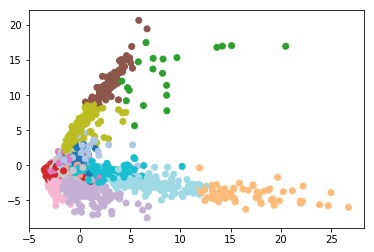

In [21]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pylab as pl

X = all_dense
targets = np.array([np.where(target == 1)[0][0] for target in train_targets])

pca = PCA(n_components=2).fit(X)
pca_2d = pca.transform(X)
kmeans = KMeans(n_clusters=14, random_state=11)
kmeans.fit(X)
pl.figure('K-means with 14 clusters')
pl.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans.labels_, cmap='tab20');

### T-SNE Graph

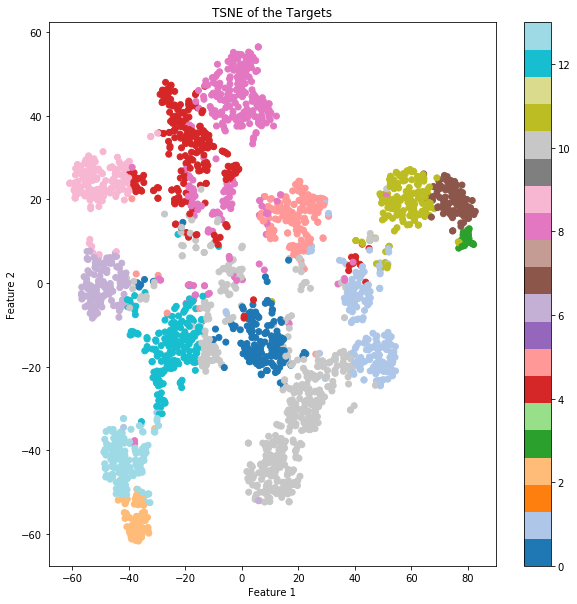

<Figure size 432x288 with 0 Axes>

In [22]:
# https://datascience.stackexchange.com/questions/31700/how-to-print-kmeans-cluster-python
from sklearn.manifold import TSNE

# Embed the features into 2 features using TSNE
X_embedded_tsne = TSNE(n_components=2, perplexity=25).fit_transform(X)

plt.figure(figsize=(10,10))
plt.scatter(X_embedded_tsne[:,0], X_embedded_tsne[:,1], c = kmeans.labels_, cmap='tab20')
plt.title('TSNE of the Targets')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar()
plt.show()
plt.tight_layout();

**Assign each training file to a cluster**

In [16]:
# Assign each training file to a cluster for understanding the clusters and troubleshooting
for cluster_num in range(14):
    mask = np.where(kmeans.labels_ == cluster_num)[0]
    for idx in mask:
        print(f"Image {train_files[idx]} is in cluster: {cluster_num}")

Image ../data/clothing2/train/white_short_dresses/white_short_dresses193.jpg is in cluster: 0
Image ../data/clothing2/train/spring_floral_dresses/spring_floral_dresses25.jpg is in cluster: 0
Image ../data/clothing2/train/spring_floral_dresses/spring_floral_dresses202.jpg is in cluster: 0
Image ../data/clothing2/train/long_sleeve_tops/long_sleeve_tops20.jpg is in cluster: 0
Image ../data/clothing2/train/spring_floral_dresses/spring_floral_dresses139.jpg is in cluster: 0
Image ../data/clothing2/train/spring_floral_dresses/spring_floral_dresses154.jpg is in cluster: 0
Image ../data/clothing2/train/spring_floral_dresses/spring_floral_dresses44.jpg is in cluster: 0
Image ../data/clothing2/train/spring_floral_dresses/spring_floral_dresses94.jpg is in cluster: 0
Image ../data/clothing2/train/long_sleeve_tops/long_sleeve_tops64.jpg is in cluster: 0
Image ../data/clothing2/train/long_sleeve_tops/long_sleeve_tops120.jpg is in cluster: 0
Image ../data/clothing2/train/spring_floral_dresses/spring_

Image ../data/clothing2/train/white_pants/white_pants68.jpg is in cluster: 10
Image ../data/clothing2/train/khaki_pants/khaki_pants157.jpg is in cluster: 10
Image ../data/clothing2/train/white_pants/white_pants78.jpg is in cluster: 10
Image ../data/clothing2/train/white_short_dresses/white_short_dresses54.jpg is in cluster: 10
Image ../data/clothing2/train/spring_floral_dresses/spring_floral_dresses114.jpg is in cluster: 10
Image ../data/clothing2/train/light_blue_short_dresses/light_blue_short_dresses287.jpg is in cluster: 10
Image ../data/clothing2/train/white_short_dresses/white_short_dresses70.jpg is in cluster: 10
Image ../data/clothing2/train/white_short_dresses/white_short_dresses159.jpg is in cluster: 10
Image ../data/clothing2/train/long_sleeve_tops/long_sleeve_tops32.jpg is in cluster: 10
Image ../data/clothing2/train/long_sleeve_tops/long_sleeve_tops114.jpg is in cluster: 10
Image ../data/clothing2/train/white_short_dresses/white_short_dresses215.jpg is in cluster: 10
Image 

In [17]:
# number of images in each cluster
[np.where(kmeans.labels_ == cluster_num, 1, 0).sum() for cluster_num in range(14)]

[158, 192, 65, 20, 248, 152, 128, 95, 302, 150, 478, 151, 192, 146]

**Confusion matrix of labels and clusters**

In [18]:
# create a confusion matrix out of the the labels and clusters
confusion = dict()

for target, label in zip(targets, kmeans.labels_):
    confusion[(target, label)] = confusion.get((target, label), 0) + 1

for target in range(14):
    line = '  '.join([f'{confusion.get((target,label),0):4d}' for label in range(14)])
    print(line)    

   0     0     0     0   105     0     0     0    33     3     0     0     0     0
   0     0     0     0     3     0     0     0   173     0     0     0     0     0
   0     0     0     0    13     1     0     0     1   130     0     0     0     0
   0     6     0     0    15   142     0     0    23     0     7     1     1     0
   0    99     0     0     1     2     0     0     0     2    35     0     0     0
   1     0     0     0     0     0     0     0     6     0    62     0   141     0
  14     1     0     4    62     2     4     4    27     2    40    10    15     6
   0     0     0     0     0     0     0    88     4     0     0   115     1     0
   1     0    61     0     0     1     0     0     6     0     2     0     0   128
   6    81     4    15    44     2     0     3    10     0    23    20    16     8
   2     1     0     0     4     0   123     0     2    13    15     0     9     2
 131     0     0     1     0     0     0     0     2     0    16     5     8     2
   0

In [19]:
for i, name in enumerate(clothing_names):
    print(i,': ', name)

0 :  black_blazer
1 :  black_short_dresses
2 :  black_skinny_jeans
3 :  brown_suede_jackets
4 :  khaki_pants
5 :  light_blue_short_dresses
6 :  long_sleeve_tops
7 :  red_short_dresses
8 :  royal_blue_short_dresses
9 :  running_shorts
10 :  skinny_blue_jeans
11 :  spring_floral_dresses
12 :  white_pants
13 :  white_short_dresses


In [20]:
# view the images of the clustered data to see if the clusters make sense
def view_image(image_path):
    plt.imshow(path_to_tensor(image_path)[0]/255.)

In [ ]:
path1 = '../data/clothing2/train/royal_blue_short_dresses/royal_blue_short_dresses177.jpg'
path2 = '../data/clothing2/train/light_blue_short_dresses/light_blue_short_dresses173.jpg'

path3 = '../data/clothing2/train/long_sleeve_tops/long_sleeve_tops72.jpg'
path4 = '../data/clothing2/train/spring_floral_dresses/spring_floral_dresses128.jpg'

path5 = '../data/clothing2/train/running_shorts/running_shorts285.jpg'

In [ ]:
view_image(path1)

In [ ]:
view_image(path2)

In [ ]:
view_image(path3)

In [ ]:
view_image(path4)

In [ ]:
view_image(path5)